In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import anderson, expon, norm, uniform, weibull_min, gumbel_l, gamma, chi2
from statsmodels.stats.diagnostic import anderson_statistic
from scipy.optimize import minimize, brentq, LinearConstraint
from sklearn.mixture import GaussianMixture

In [8]:
data = pd.read_csv('CFPREC_data1.csv')
data['diff'] = data['CFP'] - data['TFM']
data.head()

,Item,characteristic,CFP,TFM,diff
0,4021.0,Length,1516.845,1517.221,-0.376
1,4027.0,Length,2116.209,2116.412,-0.203
2,4025.0,Length,1362.367,1362.914,-0.547
3,13023.0,Length,1077.254,1077.332,-0.078
4,4028.0,Length,2709.086,2709.821,-0.735


In [6]:
characteristic_summary = data['characteristic'].value_counts().reset_index()
characteristic_summary.columns = ['Characteristic', 'Count']
characteristic_summary

,Characteristic,Count
0,Length,50
1,Length(max),12
2,Length(min),9
3,Perpendicularity,3
4,Angle,2
5,Angularity,1
6,Angle(min),1
7,Position(max),1
8,Diameter(min),1


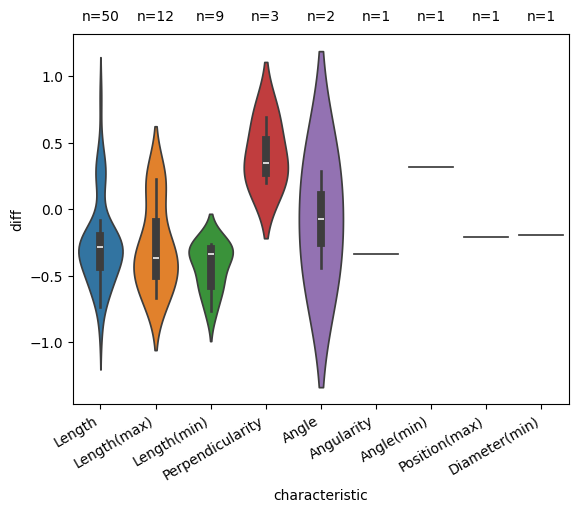

In [180]:
warnings.filterwarnings('ignore')
sns.violinplot(x=data['characteristic'], y=data['diff'], hue=data['characteristic'])
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
h = ax.get_ylim()[1]
for i, row in characteristic_summary.iterrows():
    plt.annotate(f"n={row['Count']}", (i, h), xytext=(0, 10), textcoords='offset points', ha='center')
plt.show()



Length、Length(max)、Length(min) 樣本數比較多，然後看起來有兩個峰

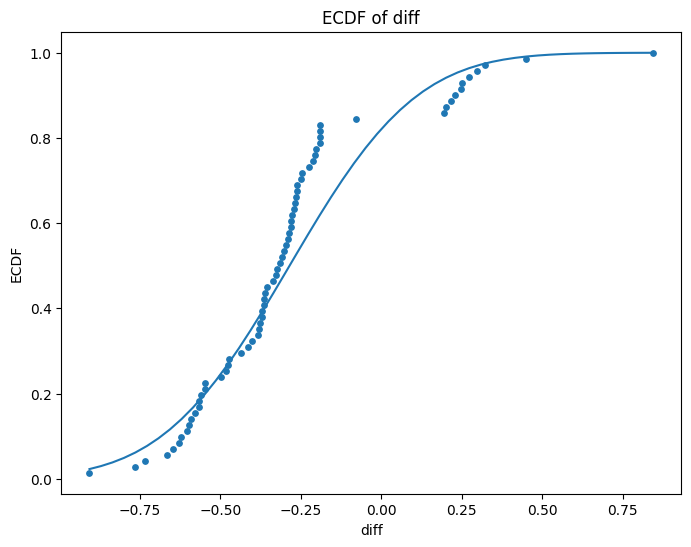

In [185]:
x = data.loc[data['characteristic'].isin(['Length', 'Length(max)', 'Length(min)']), 'diff']
# ecdf
x = np.sort(x)
y = np.arange(1, len(x)+1) / len(x)
dist = norm

def LL(theta, data): # Log likelihood
    return -np.sum(np.log(dist.pdf(data-theta[0], scale=theta[1])))
res = minimize(LL, (0, 0.1), args = (x), method='nelder-mead',
            options={'xatol': 1e-6, 'disp': False})
# print(res.x)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(x, y, s=15)
ax.set_xlabel('diff')
ax.set_ylabel('ECDF')
ax.set_title('ECDF of diff')
ax.plot(np.linspace(x[0], x[-1], 50), \
        dist.cdf(np.linspace(x[0], x[-1], 50), loc=res.x[0], scale=res.x[1]), label='Normal')
fig.show()

從 empirical cdf 看的出來不像常態，而且有兩群。
  
嘗試用 mixturenormal 分成兩群結果只是分成大於 0 跟小於 0，跟前面的觀察吻合。
  
看起來比 0 大的比較像 noncentral exponential；比 0 小的像 normal (可能也沒那麼像)。代表 error 可能有兩種來源: exponential 跟 normal。


[0.195      0.12545464]


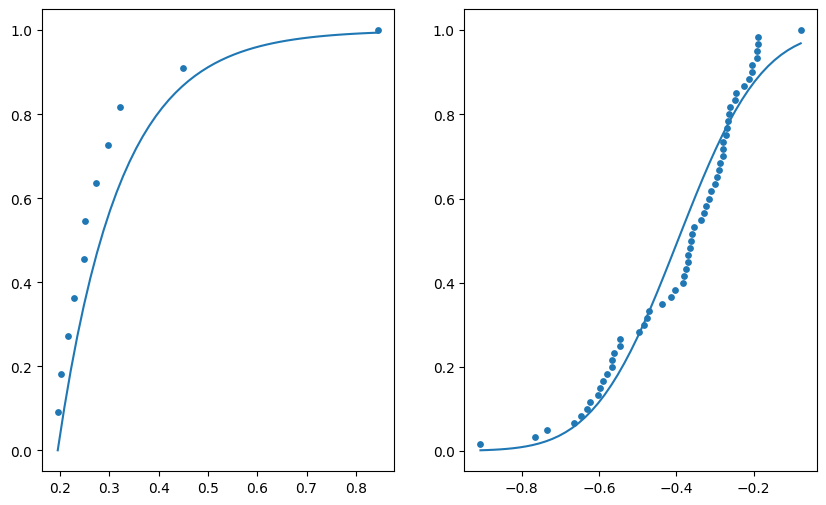

In [149]:
x = (data.loc[data['characteristic'].isin(['Length', 'Length(max)', 'Length(min)']), 'diff']).to_numpy()
gm = GaussianMixture(n_components=2, random_state=0).fit(x.reshape(-1, 1))
# print(gm.means_)
group = gm.fit_predict(x.reshape(-1, 1))

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# for i, g in enumerate(np.unique(group)):
#     x_g = np.sort(x[group==g])
#     ax[i].scatter(x_g, np.arange(1, np.sum(group==g)+1) / np.sum(group==g), s=15)
#     ax[i].plot(np.linspace(x_g[0], x_g[-1], 50), \
#                norm.cdf(np.linspace(x_g[0], x_g[-1], 50), gm.means_[i], np.sqrt(gm.covariances_[i])).flatten())
x_g = np.sort(x[group==1])
def LL(theta, data): # Log likelihood
    return -np.sum(np.log(expon.pdf(data, loc = theta[0], scale=theta[1])))
res = minimize(LL, (0, 0.1), args = (x_g), method='nelder-mead',
            options={'xatol': 1e-6, 'disp': False})
print(res.x)
ax[0].scatter(x_g, np.arange(1, len(x_g)+1) / len(x_g), s=15)
ax[0].plot(np.linspace(x_g[0], x_g[-1], 50), \
            expon.cdf(np.linspace(x_g[0], x_g[-1], 50), loc = res.x[0], scale = res.x[1]).flatten())
x_g = np.sort(x[group==0])
ax[1].scatter(x_g, np.arange(1, len(x_g)+1) / len(x_g), s=15)
ax[1].plot(np.linspace(x_g[0], x_g[-1], 50), \
            norm.cdf(np.linspace(x_g[0], x_g[-1], 50), gm.means_[0], np.sqrt(gm.covariances_[0])).flatten())
    
fig.show()

In [151]:
# 看這兩群的數字
print(np.sort(x[group==1]))
print(np.sort(x[group==0]))

[0.195 0.201 0.216 0.229 0.248 0.25  0.272 0.298 0.321 0.45  0.845]
[-0.907 -0.765 -0.735 -0.665 -0.648 -0.63  -0.624 -0.603 -0.598 -0.59
 -0.58  -0.567 -0.566 -0.561 -0.547 -0.547 -0.497 -0.484 -0.476 -0.472
 -0.437 -0.415 -0.403 -0.382 -0.381 -0.376 -0.371 -0.37  -0.364 -0.363
 -0.36  -0.355 -0.335 -0.328 -0.323 -0.315 -0.309 -0.301 -0.295 -0.29
 -0.286 -0.28  -0.28  -0.278 -0.271 -0.268 -0.265 -0.263 -0.262 -0.249
 -0.246 -0.226 -0.212 -0.205 -0.203 -0.19  -0.19  -0.189 -0.189 -0.078]


檢定 exponential dist. 的平均是不是 0

In [174]:
def LL0(theta, data): # Log likelihood
    return -np.sum(np.log(expon.pdf(data, loc = theta[0], scale=theta[1])))
res = minimize(LL, (-0.1, 0.1), args = (x[group==1]), method='SLSQP',
            options={'xatol': 1e-6, 'disp': False}, constraints=LinearConstraint([1, 1], 0, 0))
LL0_value = res.fun
def LL1(theta, data): # Log likelihood
    return -np.sum(np.log(expon.pdf(data, loc = theta[0], scale=theta[1])))
res = minimize(LL, (0, 0.1), args = (x[group==1]), method='Nelder-Mead',
            options={'xatol': 1e-6, 'disp': False})
LL1_value = res.fun
print(2*(LL0_value - LL1_value))
print('p-value={}'.format(chi2.sf(2*(LL0_value - LL1_value), 1)))

42.63153264814073
p-value=6.608541074381676e-11


結論為不是 0。

檢定 normal dist. 的平均是不是 0

In [177]:
x_bar = np.mean(x[group==0])
s = np.std(x[group==0])
t = (x_bar - 0) / (s / np.sqrt(len(x[group==0])))
print(t)

-18.075245727069653


t-value 一看就知道平均不是 0。